In [1]:
import torch as pt
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
transforms_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761)),
])

In [3]:
device = "cuda" if pt.cuda.is_available() else "cpu"
latent_dim = 384
batch_size = 64
gen_lr = 2e-4
disc_lr = 2e-4
epochs = 50
stats = (0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)

In [4]:
train_dataset = CIFAR10("./data", train=True, download=True, transform=transforms_)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10("./data", train=False, download=True, transform=transforms_)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [6]:
def show_images(images, n_max=batch_size):
    _, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach().cpu()[:n_max]), nrow=8).permute(1, 2, 0))

In [7]:
from torch import nn
from torch.nn import functional as F

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.conv_transpose_block = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, padding=0, stride=2, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True), # ((384 - 4) + (2*0) / 2) + 1 = 191

            nn.ConvTranspose2d(512, 256, kernel_size=4, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True), # ((191 - 4) + (2*1) / 2) + 1 = 95

            nn.ConvTranspose2d(256, 128, kernel_size=4, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True), # ((95 - 4) + (2*1) / 2) + 1 = 47

            nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True), # ((47 - 4) + (2*1) / 2) + 1 = 23

            nn.ConvTranspose2d(64, 32, kernel_size=4, padding=1, stride=2, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True), # ((23 - 4) + (2*1) / 2) + 1 = 11

            nn.Conv2d(32, 3, kernel_size=4, padding=1, stride=2, bias=True),
            # ((11 - 4) + (2*1) / 2) + 1 = 5
        )

    def forward(self, x):
        x = self.conv_transpose_block(x)
        return F.tanh(x)

/home/parth/miniconda3/envs/env-pytorch/lib/python3.8/site-packages/torch/nn/modules/conv.py:956: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv_transpose2d(


torch.Size([64, 3, 32, 32])


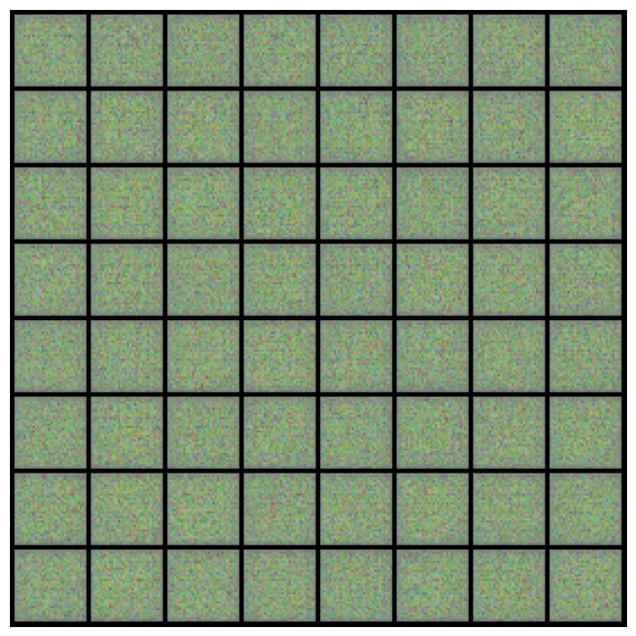

In [9]:
generator = Generator(latent_dim).to(device)

xb = pt.randn(batch_size, latent_dim, 1, 1) # random latent tensors
fake_images = generator(xb.to(device))
print(fake_images.shape)
show_images(fake_images)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.2, inplace=True),
            # (32 – 3 + (2*1)) / 1 + 1 = 32 / maxpool = 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.2, inplace=True),
            # (16 – 3 + (2*1)) / 1 + 1 = 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.2, inplace=True),
            # (8 – 3 + (2*1)) / 1 + 1 = 4
        )
        self.dense1 = nn.Linear(256*4*4, 512)
        self.dropout = nn.Dropout(0.5)
        self.dense2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.discriminator(x)
        x = x.view(-1, 256*4*4)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return F.sigmoid(x)

In [11]:
discriminator = Discriminator().to(device)

In [12]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = pt.randn(batch_size, latent_dim, 1, 1, device=device)
    fake_images = generator.train()(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = pt.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [13]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator.train()(real_images)
    real_targets = pt.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    # real_score = pt.mean(real_preds).item()

    # Generate fake images
    latent = pt.randn(batch_size, latent_dim, 1, 1, device=device)
    fake_images = generator.train()(latent)

    # Pass fake images through discriminator
    fake_targets = pt.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator.train()(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    # fake_score = pt.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss # (... + ...) / 2
    loss.backward()
    opt_d.step()
    return loss.item(), real_loss.detach().cpu().item(), fake_loss.detach().cpu().item() # real_score, fake_score

In [14]:
import os

sample_dir = 'generated-images'
os.makedirs(sample_dir, exist_ok=True)

In [15]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator.eval()(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(
        denorm(fake_images.detach().cpu()),
        os.path.join(sample_dir, fake_fname),
        nrow=8
    )
    print('Saving', fake_fname)
    if show:
        _, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.detach().cpu(), nrow=8).permute(1, 2, 0))
        plt.show()

In [16]:
opt_g = pt.optim.Adam(generator.parameters(), lr=gen_lr, betas=(0.5, 0.999))
opt_d = pt.optim.Adam(discriminator.parameters(), lr=disc_lr, betas=(0.5, 0.999))

fixed_latent = pt.randn(64, latent_dim, 1, 1, device=device)

In [17]:
import numpy as np
from tqdm import tqdm

In [18]:
losses_g, losses_d = [], []
real_scores, fake_scores = [], []

for epoch in range(epochs):
    batch_loss_g, batch_loss_d = [], []
    batch_real_score, batch_fake_score = [], []

    for loader in train_loader, test_loader:
        # Train discriminator
        for real_images, _ in tqdm(loader):
            loss_d, real_score, fake_score = train_discriminator(real_images.to(device), opt_d)
            batch_loss_d.append(loss_d)
            batch_real_score.append(real_score)
            batch_fake_score.append(fake_score)
            # Train generator
            loss_g = train_generator(opt_g)
            batch_loss_g.append(loss_g)

    # Record losses & scores
    losses_g.append(np.mean(batch_loss_g))
    losses_d.append(np.mean(batch_loss_d))
    real_scores.append(np.mean(batch_real_score))
    fake_scores.append(np.mean(batch_fake_score))

    batch_loss_g, batch_loss_d = [], []
    batch_real_score, batch_fake_score = [], []

    # Save generated images
    save_samples(epoch+1, fixed_latent, show=False)

    # Log losses & scores (last batch)
    print(f"Epoch [{epoch+1}/{epochs}], loss_g: {loss_g:.4f}, loss_d: {loss_d:.4f},"
          + f" real_score: {real_score:.4f}, fake_score: {fake_score:.4f}\n")

100%|██████████| 157/157 [00:08<00:00, 18.97it/s]


Saving generated-images-0001.png
Epoch [1/50], loss_g: 0.7807, loss_d: 1.3114, real_score: 0.9717, fake_score: 0.3397



100%|██████████| 157/157 [00:08<00:00, 18.83it/s]


Saving generated-images-0002.png
Epoch [2/50], loss_g: 1.6460, loss_d: 1.3531, real_score: 0.4834, fake_score: 0.8697



100%|██████████| 157/157 [00:08<00:00, 18.65it/s]


Saving generated-images-0003.png
Epoch [3/50], loss_g: 0.6692, loss_d: 1.2900, real_score: 0.7258, fake_score: 0.5642



100%|██████████| 157/157 [00:08<00:00, 18.47it/s]


Saving generated-images-0004.png
Epoch [4/50], loss_g: 0.7710, loss_d: 1.2874, real_score: 0.8839, fake_score: 0.4034



100%|██████████| 157/157 [00:08<00:00, 18.43it/s]


Saving generated-images-0005.png
Epoch [5/50], loss_g: 0.9623, loss_d: 1.5541, real_score: 1.0510, fake_score: 0.5031



100%|██████████| 157/157 [00:08<00:00, 18.47it/s]


Saving generated-images-0006.png
Epoch [6/50], loss_g: 0.6951, loss_d: 1.1260, real_score: 0.6907, fake_score: 0.4353



100%|██████████| 157/157 [00:08<00:00, 18.27it/s]


Saving generated-images-0007.png
Epoch [7/50], loss_g: 0.5847, loss_d: 1.2302, real_score: 0.9889, fake_score: 0.2413



100%|██████████| 157/157 [00:08<00:00, 18.07it/s]


Saving generated-images-0008.png
Epoch [8/50], loss_g: 0.8197, loss_d: 1.3395, real_score: 0.7991, fake_score: 0.5404



100%|██████████| 157/157 [00:08<00:00, 18.35it/s]


Saving generated-images-0009.png
Epoch [9/50], loss_g: 2.1858, loss_d: 1.2906, real_score: 0.2267, fake_score: 1.0639



100%|██████████| 157/157 [00:08<00:00, 18.26it/s]


Saving generated-images-0010.png
Epoch [10/50], loss_g: 1.3138, loss_d: 1.1445, real_score: 0.6707, fake_score: 0.4739



100%|██████████| 157/157 [00:08<00:00, 18.28it/s]


Saving generated-images-0011.png
Epoch [11/50], loss_g: 1.6746, loss_d: 0.9613, real_score: 0.3521, fake_score: 0.6093



100%|██████████| 157/157 [00:08<00:00, 18.34it/s]


Saving generated-images-0012.png
Epoch [12/50], loss_g: 0.8910, loss_d: 1.4185, real_score: 1.1078, fake_score: 0.3106



100%|██████████| 157/157 [00:08<00:00, 18.25it/s]


Saving generated-images-0013.png
Epoch [13/50], loss_g: 0.9879, loss_d: 1.0663, real_score: 0.6678, fake_score: 0.3985



100%|██████████| 157/157 [00:08<00:00, 18.21it/s]


Saving generated-images-0014.png
Epoch [14/50], loss_g: 1.5243, loss_d: 0.8231, real_score: 0.2303, fake_score: 0.5928



100%|██████████| 157/157 [00:08<00:00, 18.22it/s]


Saving generated-images-0015.png
Epoch [15/50], loss_g: 0.6072, loss_d: 1.5502, real_score: 1.2772, fake_score: 0.2731



100%|██████████| 157/157 [00:08<00:00, 18.03it/s]


Saving generated-images-0016.png
Epoch [16/50], loss_g: 1.5715, loss_d: 0.7125, real_score: 0.4836, fake_score: 0.2288



100%|██████████| 157/157 [00:08<00:00, 18.16it/s]


Saving generated-images-0017.png
Epoch [17/50], loss_g: 1.5771, loss_d: 0.6860, real_score: 0.2140, fake_score: 0.4719



100%|██████████| 157/157 [00:08<00:00, 18.13it/s]


Saving generated-images-0018.png
Epoch [18/50], loss_g: 2.4026, loss_d: 1.0167, real_score: 0.1752, fake_score: 0.8415



100%|██████████| 157/157 [00:08<00:00, 17.80it/s]


Saving generated-images-0019.png
Epoch [19/50], loss_g: 2.5068, loss_d: 0.9184, real_score: 0.2474, fake_score: 0.6710



100%|██████████| 157/157 [00:08<00:00, 18.01it/s]


Saving generated-images-0020.png
Epoch [20/50], loss_g: 0.4219, loss_d: 1.2356, real_score: 0.8442, fake_score: 0.3915



100%|██████████| 157/157 [00:37<00:00,  4.20it/s]


Saving generated-images-0021.png
Epoch [21/50], loss_g: 2.5291, loss_d: 0.8595, real_score: 0.2358, fake_score: 0.6238



100%|██████████| 157/157 [00:08<00:00, 18.91it/s]


Saving generated-images-0022.png
Epoch [22/50], loss_g: 0.5851, loss_d: 1.3471, real_score: 1.1342, fake_score: 0.2129



100%|██████████| 157/157 [00:08<00:00, 18.32it/s]


Saving generated-images-0023.png
Epoch [23/50], loss_g: 1.1278, loss_d: 0.9750, real_score: 0.8786, fake_score: 0.0963



100%|██████████| 157/157 [00:08<00:00, 18.21it/s]


Saving generated-images-0024.png
Epoch [24/50], loss_g: 2.3895, loss_d: 1.4614, real_score: 0.2602, fake_score: 1.2012



100%|██████████| 157/157 [00:08<00:00, 18.18it/s]


Saving generated-images-0025.png
Epoch [25/50], loss_g: 1.8673, loss_d: 1.4859, real_score: 0.1975, fake_score: 1.2884



100%|██████████| 157/157 [00:08<00:00, 18.15it/s]


Saving generated-images-0026.png
Epoch [26/50], loss_g: 1.2914, loss_d: 1.1352, real_score: 0.7042, fake_score: 0.4310



100%|██████████| 157/157 [00:08<00:00, 17.98it/s]


Saving generated-images-0027.png
Epoch [27/50], loss_g: 2.0537, loss_d: 0.9094, real_score: 0.5019, fake_score: 0.4074



100%|██████████| 157/157 [00:08<00:00, 18.10it/s]


Saving generated-images-0028.png
Epoch [28/50], loss_g: 1.3476, loss_d: 0.6809, real_score: 0.3527, fake_score: 0.3283



100%|██████████| 157/157 [00:08<00:00, 18.06it/s]


Saving generated-images-0029.png
Epoch [29/50], loss_g: 2.1331, loss_d: 0.6910, real_score: 0.3057, fake_score: 0.3853



100%|██████████| 157/157 [00:08<00:00, 17.74it/s]


Saving generated-images-0030.png
Epoch [30/50], loss_g: 3.3381, loss_d: 0.9887, real_score: 0.0670, fake_score: 0.9217



100%|██████████| 157/157 [00:08<00:00, 18.16it/s]


Saving generated-images-0031.png
Epoch [31/50], loss_g: 2.3685, loss_d: 1.1503, real_score: 0.1468, fake_score: 1.0036



100%|██████████| 157/157 [00:08<00:00, 18.16it/s]


Saving generated-images-0032.png
Epoch [32/50], loss_g: 1.2230, loss_d: 1.3357, real_score: 1.0883, fake_score: 0.2474



100%|██████████| 157/157 [00:08<00:00, 18.08it/s]


Saving generated-images-0033.png
Epoch [33/50], loss_g: 1.7500, loss_d: 1.0389, real_score: 0.6188, fake_score: 0.4201



100%|██████████| 157/157 [00:08<00:00, 17.90it/s]


Saving generated-images-0034.png
Epoch [34/50], loss_g: 1.8751, loss_d: 0.9219, real_score: 0.7879, fake_score: 0.1340



100%|██████████| 157/157 [00:08<00:00, 18.16it/s]


Saving generated-images-0035.png
Epoch [35/50], loss_g: 1.3076, loss_d: 0.7243, real_score: 0.5345, fake_score: 0.1897



100%|██████████| 157/157 [00:08<00:00, 18.31it/s]


Saving generated-images-0036.png
Epoch [36/50], loss_g: 0.9289, loss_d: 1.1896, real_score: 1.0337, fake_score: 0.1559



100%|██████████| 157/157 [00:08<00:00, 18.31it/s]


Saving generated-images-0037.png
Epoch [37/50], loss_g: 2.5435, loss_d: 0.7379, real_score: 0.1484, fake_score: 0.5894



100%|██████████| 157/157 [00:08<00:00, 18.24it/s]


Saving generated-images-0038.png
Epoch [38/50], loss_g: 2.0887, loss_d: 0.6030, real_score: 0.0967, fake_score: 0.5063



100%|██████████| 157/157 [00:08<00:00, 18.27it/s]


Saving generated-images-0039.png
Epoch [39/50], loss_g: 1.0431, loss_d: 0.8621, real_score: 0.5302, fake_score: 0.3319



100%|██████████| 157/157 [00:08<00:00, 18.19it/s]


Saving generated-images-0040.png
Epoch [40/50], loss_g: 2.5936, loss_d: 0.7881, real_score: 0.1266, fake_score: 0.6615



100%|██████████| 157/157 [00:08<00:00, 18.29it/s]


Saving generated-images-0041.png
Epoch [41/50], loss_g: 2.6161, loss_d: 0.8759, real_score: 0.1534, fake_score: 0.7225



100%|██████████| 157/157 [00:08<00:00, 18.30it/s]


Saving generated-images-0042.png
Epoch [42/50], loss_g: 0.7739, loss_d: 1.4431, real_score: 1.2881, fake_score: 0.1550



100%|██████████| 157/157 [00:08<00:00, 18.26it/s]


Saving generated-images-0043.png
Epoch [43/50], loss_g: 2.3222, loss_d: 0.5684, real_score: 0.2037, fake_score: 0.3646



100%|██████████| 157/157 [00:08<00:00, 18.21it/s]


Saving generated-images-0044.png
Epoch [44/50], loss_g: 2.6649, loss_d: 0.6078, real_score: 0.4785, fake_score: 0.1294



100%|██████████| 157/157 [00:08<00:00, 18.31it/s]


Saving generated-images-0045.png
Epoch [45/50], loss_g: 2.9647, loss_d: 1.5959, real_score: 0.1325, fake_score: 1.4634



100%|██████████| 157/157 [00:08<00:00, 18.28it/s]


Saving generated-images-0046.png
Epoch [46/50], loss_g: 1.3667, loss_d: 0.8175, real_score: 0.7129, fake_score: 0.1045



100%|██████████| 157/157 [00:08<00:00, 17.99it/s]


Saving generated-images-0047.png
Epoch [47/50], loss_g: 2.5060, loss_d: 0.3828, real_score: 0.0124, fake_score: 0.3704



100%|██████████| 157/157 [00:08<00:00, 18.04it/s]


Saving generated-images-0048.png
Epoch [48/50], loss_g: 0.7018, loss_d: 1.2435, real_score: 1.1605, fake_score: 0.0830



100%|██████████| 157/157 [00:08<00:00, 18.17it/s]


Saving generated-images-0049.png
Epoch [49/50], loss_g: 4.1863, loss_d: 0.4916, real_score: 0.0355, fake_score: 0.4561



100%|██████████| 157/157 [00:08<00:00, 18.03it/s]


Saving generated-images-0050.png
Epoch [50/50], loss_g: 2.4476, loss_d: 0.4167, real_score: 0.1200, fake_score: 0.2967



Text(0.5, 1.0, 'Fake Images Discriminator Scores')

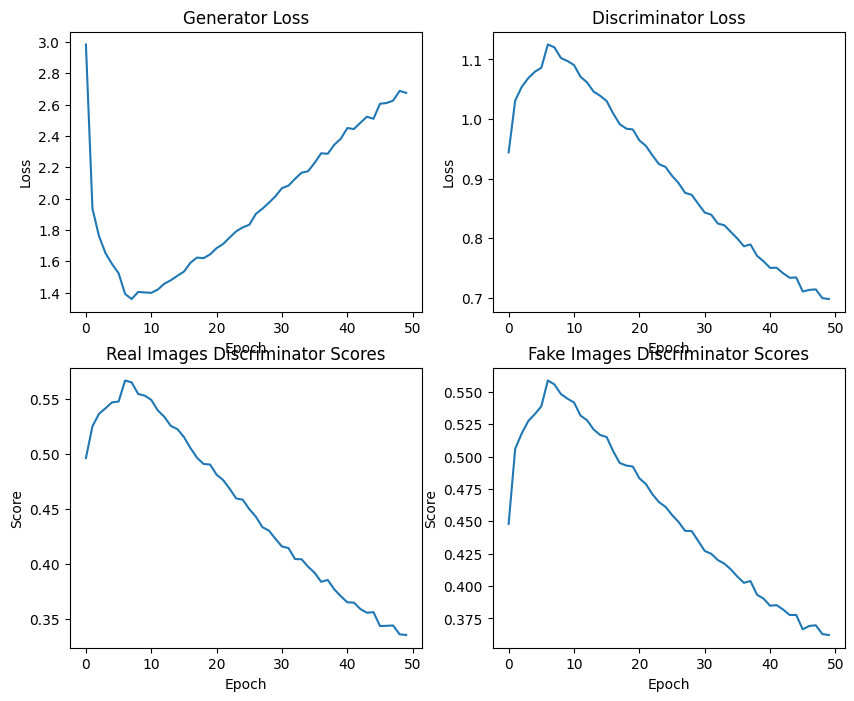

In [19]:
plt.figure(figsize=(10, 8), dpi=100)

plt.subplot(2, 2, 1)
plt.plot(losses_g, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')

plt.subplot(2, 2, 2)
plt.plot(losses_d, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')

plt.subplot(2, 2, 3)
plt.plot(real_scores, '-')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Real Images Discriminator Scores')

plt.subplot(2, 2, 4)
plt.plot(fake_scores, '-')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Fake Images Discriminator Scores')

In [25]:
pt.save(generator.state_dict(), "models/generator-model")
pt.save(discriminator.state_dict(), "models/discriminator-model")